In [7]:
# Load the essential libraries
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.datasets import load_svmlight_file

In [34]:
def load_dataset():
    # Load the training and testing data from the given files.
    # 124 features = 123 given features from the dataset + 1 bias
    x_train, y_train = load_svmlight_file("Dataset/a9a", n_features=124)
    x_test, y_test = load_svmlight_file("Dataset/a9a.t", n_features=124)

    # Change the data type to np.ndarray and add the bias term as the 124th feature
    x_train, x_test = x_train.toarray(), x_test.toarray()
    x_train[:,123], x_test[:,123] = 1, 1
    
    # Make the output binary
    y_train = [0 if sample == -1 else 1 for sample in y_train]
    y_test = [0 if sample == -1 else 1 for sample in y_test]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()
    

In [35]:
acc_train = {}
acc_test = {}

In [4]:
def sigmoid(val):
    return 1 / (1+np.exp(-val))


def update_weights(x, w, y, _lambda=0):
    mu = sigmoid(x @ w)
    R = np.diag(np.multiply(mu, 1-mu))
    # Hessian matrix
    H = - (np.transpose(x)@R@x) - (_lambda*np.identity(124))
    # Gradient loss term
    G = np.transpose(x)@(y-mu) - _lambda * w
    # Weight update
    w_new = w - np.linalg.pinv(H) @ G

    return w_new


def accuracy(x, w, y, _lambda, mode):
    p = sigmoid(x@w)
    p = [0 if px <= 0.5 else 1 for px in p]

    num_correct = 0
    for i in range(len(p)):
        if (p[i] == y[i]):
            num_correct += 1

    acc = num_correct * 100 / len(p)
    
    print("Accuracy:", acc)
    if (mode == "train"):
        if (_lambda in acc_train.keys()):
            acc_train[_lambda].append(acc)
        else:
            acc_train[_lambda] = [acc]
    else:
        if (_lambda in acc_test.keys()):
            acc_test[_lambda].append(acc)
        else:
            acc_test[_lambda] = [acc]



In [5]:
def train_model(x_train, w, y_train,_lambda, epoch=0):
    print("Training Epoch ==> %d" % epoch)

    if (epoch != 0):
        w = update_weights(x_train, w, y_train, _lambda)

    accuracy(x_train, w, y_train, _lambda, "train")

    return w


In [6]:

def test_model(x_test, w, y_test, epoch=0):
    print("Testing Epoch ==> %d" % epoch)
    accuracy(x_test, w, y_test, _lambda, "")


In [18]:
epochs = 10
# lambdas = [0, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]
lambdas = [0]

for _lambda in lambdas:
    num_repeat = 0
    w = np.zeros((1, 124), dtype='float64')[0]
    w = train_model(x_train, w, y_train, _lambda, 0)
    test_model(x_test, w, y_test, 0)

    for epoch in range(1, epochs+1):
        # Train the model based on the train data
        w = train_model(x_train, w, y_train, _lambda, epoch)
        # Test the model
        test_model(x_test, w, y_test, epoch)




Training Epoch ==> 0
Accuracy: 75.91904425539757
Testing Epoch ==> 0
Accuracy: 76.3773723972729
Training Epoch ==> 1
Accuracy: 84.52750222659009
Testing Epoch ==> 1
Accuracy: 84.5279773969658
Training Epoch ==> 2
Accuracy: 84.81619114892048
Testing Epoch ==> 2
Accuracy: 84.81665745347337
Training Epoch ==> 3
Accuracy: 84.9451798163447
Testing Epoch ==> 3
Accuracy: 84.93950003071065
Training Epoch ==> 4
Accuracy: 84.93289518135192
Testing Epoch ==> 4
Accuracy: 84.9640685461581
Training Epoch ==> 5
Accuracy: 84.91139707011456
Testing Epoch ==> 5
Accuracy: 84.99477919046741
Training Epoch ==> 6
Accuracy: 84.91446822886275
Testing Epoch ==> 6
Accuracy: 84.99477919046741
Training Epoch ==> 7
Accuracy: 84.91446822886275
Testing Epoch ==> 7
Accuracy: 84.99477919046741
Training Epoch ==> 8
Accuracy: 84.91446822886275
Testing Epoch ==> 8
Accuracy: 84.99477919046741
Training Epoch ==> 9
Accuracy: 84.91446822886275
Testing Epoch ==> 9
Accuracy: 84.99477919046741
Training Epoch ==> 10
Accuracy: 84

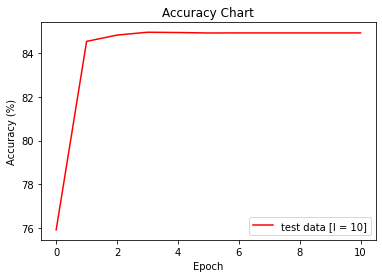

In [19]:

acc1 = acc_test[0]
acc2 = acc_train[0]


plt.plot(acc2, color='red', label='test data [l = 10]')
plt.legend()
plt.title('Accuracy Chart')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.show()

In [31]:
kf = KFold(n_splits=10)
epochs = 10
lambdas = [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]
mse_dict = {}
folds_used = 0

def MSE (x, w, y):
    p = sigmoid(x@w)
    p = [0 if px <= 0.5 else 1 for px in p]
    y = np.array(y)

    mse = (np.square(y - p)).mean(axis=0)
    print("MSE ", mse)
    return mse


for _lambda in lambdas:
    mse_average = 0
    for train_idx, test_idx in kf.split(x_train):
        folds_used +=1
        print("Using fold %d"%(folds_used))
        print(train_idx, test_idx)
        x_train_cv= x_train[train_idx]
        y_train_cv= np.array(y_train)[train_idx]
        x_test_cv, y_test_cv = x_train[test_idx], np.array(y_train)[test_idx]

        w = np.zeros((1, 124), dtype='float64')[0]
        w = train_model(x_train_cv, w, y_train_cv, _lambda, 0)
        mse_sum = MSE(x_test, w, y_test)
        for epoch in range(1, epochs):
            # Train the model based on the train data
            w = train_model(x_train, w, y_train, _lambda, epoch)
            # Test the model
            mse_sum += MSE(x_test, w, y_test)

        mse_average = mse_average + (mse_sum/epochs)
    mse_dict[_lambda] = mse_average / 10

92
MSE  0.14925373134328357
Using fold 67
[    0     1     2 ... 32558 32559 32560] [19537 19538 19539 ... 22790 22791 22792]
Training Epoch ==> 0
Accuracy: 75.88466132059375
MSE  0.23622627602727106
Training Epoch ==> 1
Accuracy: 84.447652099137
MSE  0.1541674344327744
Training Epoch ==> 2
Accuracy: 84.69641595774085
MSE  0.15054357840427493
Training Epoch ==> 3
Accuracy: 84.74555449771199
MSE  0.1498065229408513
Training Epoch ==> 4
Accuracy: 84.79469303768312
MSE  0.14919231005466493
Training Epoch ==> 5
Accuracy: 84.79162187893492
MSE  0.1493151526319022
Training Epoch ==> 6
Accuracy: 84.79162187893492
MSE  0.14925373134328357
Training Epoch ==> 7
Accuracy: 84.79162187893492
MSE  0.14925373134328357
Training Epoch ==> 8
Accuracy: 84.79162187893492
MSE  0.14925373134328357
Training Epoch ==> 9
Accuracy: 84.79162187893492
MSE  0.14925373134328357
Using fold 68
[    0     1     2 ... 32558 32559 32560] [22793 22794 22795 ... 26046 26047 26048]
Training Epoch ==> 0
Accuracy: 75.9870329

In [32]:
mse_dict

{0.01: 0.15940052822308215,
 0.1: 0.15940667035194395,
 1: 0.15932068054787793,
 2: 0.15920398009950246,
 5: 0.1589337264295805,
 10: 0.15890301578527113,
 20: 0.15862661998648733,
 50: 0.1582089552238806,
 100: 0.1585160616669738}

In [48]:
mini = 1
idx =0
for key, value in mse_dict.items():
    if (value <mini and key != 50):
        mini = value
        idx = key

idx

100

In [49]:
epochs = 7
# lambdas = [0, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]
lambdas = [100]

for _lambda in lambdas:
    num_repeat = 0
    w = np.zeros((1, 124), dtype='float64')[0]
    w = train_model(x_train, w, y_train, _lambda, 0)
    test_model(x_test, w, y_test, 0)

    for epoch in range(1, epochs+1):
        # Train the model based on the train data
        w = train_model(x_train, w, y_train, _lambda, epoch)
        # Test the model
        test_model(x_test, w, y_test, epoch)

Training Epoch ==> 0
Accuracy: 75.91904425539757
Testing Epoch ==> 0
Accuracy: 76.3773723972729
Training Epoch ==> 1
Accuracy: 84.35858849543934
Testing Epoch ==> 1
Accuracy: 84.57097229899884
Training Epoch ==> 2
Accuracy: 84.53671570283468
Testing Epoch ==> 2
Accuracy: 84.91493151526319
Training Epoch ==> 3
Accuracy: 84.5919965603022
Testing Epoch ==> 3
Accuracy: 85.09305325225723
Training Epoch ==> 4
Accuracy: 84.62577930653235
Testing Epoch ==> 4
Accuracy: 85.09305325225723
Training Epoch ==> 5
Accuracy: 84.62270814778415
Testing Epoch ==> 5
Accuracy: 85.08691112339537
Training Epoch ==> 6
Accuracy: 84.62270814778415
Testing Epoch ==> 6
Accuracy: 85.08691112339537
Training Epoch ==> 7
Accuracy: 84.62270814778415
Testing Epoch ==> 7
Accuracy: 85.08691112339537


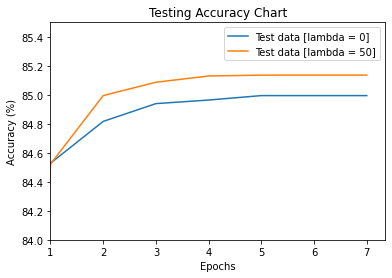

In [93]:
acc_test_0 = acc_test[0]
acc_test_50 = acc_test[50]

fig, ax = plt.subplots()
ax.plot(acc_test_0, label='Test data [lambda = 0]')
ax.plot(acc_test_50, label='Test data [lambda = 50]')
ax.set_title("Testing Accuracy Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
plt.xlim(left=1)
plt.ylim(84,85.5)
ax.set_xticks(list(range(1, 8)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Acc_test", dpi=300)


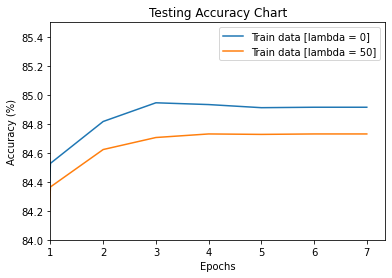

In [95]:
acc_train_0  = acc_train[0]
acc_train_50 = acc_train[50]

fig, ax = plt.subplots()
ax.plot(acc_train_0, label='Train data [lambda = 0]')
ax.plot(acc_train_50, label='Train data [lambda = 50]')
ax.set_title("Testing Accuracy Chart")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
plt.xlim(left=1)
plt.ylim(84,85.5)
ax.set_xticks(list(range(1, 8)))
ax.legend()
plt.show()

fig = ax.get_figure()
fig.savefig("Figures/Acc_train", dpi=300)

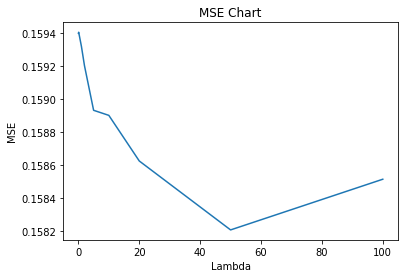

In [70]:
fig, ax = plt.subplots()
ax.plot(mse_dict.keys(), mse_dict.values())
ax.set_title("MSE Chart")
ax.set_xlabel("Lambda")
ax.set_ylabel("MSE")
plt.show()

fig = ax.get_figure()
fig.savefig("MSE", dpi=300)